## An Electrode Design Optimisation Example

NOTE: This is a brittle example, the classes and methods below will be integrated into PyBOP in a future release.

A design optimisation example loosely based on work by L.D. Couto available at [[1]](https://doi.org/10.1016/j.energy.2022.125966).

The target is to maximise the gravimetric energy density over a range of possible design parameter values, including for example:

cross-sectional area = height x width (only need change one), electrode widths, particle radii, volume fractions and separator width.

### Setting up the Environment

Before we begin, we need to ensure that we have all the necessary tools. We will install PyBOP from its development branch and upgrade some dependencies:

In [ ]:
%pip install --upgrade pip ipywidgets pybamm -q
%pip install pybop -q

Next, we import the added packages plus any additional dependencies,

In [ ]:
import pybop

## Optimising the Parameters

First, we define the model to be used for the parameter optimisation,

In [ ]:
parameter_set = pybop.ParameterSet.pybamm("Chen2020")
model = pybop.lithium_ion.SPMe(parameter_set=parameter_set)

Next, we define the model parameters for optimisation. Furthermore, PyBOP provides functionality to define a prior for the parameters. The initial parameters values used in the optimisation will be randomly drawn from the prior distribution.

In [ ]:
parameters = pybop.Parameters(
    pybop.Parameter(
        "Positive electrode thickness [m]",
        prior=pybop.Gaussian(7.56e-05, 0.05e-05),
        bounds=[65e-06, 10e-05],
    ),
    pybop.Parameter(
        "Positive particle radius [m]",
        prior=pybop.Gaussian(5.22e-06, 0.05e-06),
        bounds=[2e-06, 9e-06],
    ),
)

Next, we construct the experiment for design optimisation and the initial state-of-charge,

In [ ]:
experiment = pybop.Experiment(
    ["Discharge at 1C until 2.5 V (5 seconds period)"],
)

We can now define the output signal, the problem (which combines the model with the dataset) and construct a cost function which in this example is the `GravimetricEnergyDensity()` used to maximise the gravimetric energy density of the cell.

In [ ]:
problem = pybop.DesignProblem(model, parameters, experiment, init_soc=1.0)
cost = pybop.GravimetricEnergyDensity(problem)

Let's construct PyBOP's optimisation class. This class provides the methods needed to fit the forward model. For this example, we use particle swarm optimisation (PSO). Due to the computational requirements of the design optimisation methods, we limit the number of iterations to 15 for this example.

In [ ]:
optim = pybop.PSO(cost, verbose=True, max_iterations=15)

Finally, we run the optimisation and return the values obtained,

In [ ]:
x, final_cost = optim.run()
print("Estimated parameters:", x)
print(f"Initial gravimetric energy density: {-cost(optim.x0):.2f} Wh.kg-1")
print(f"Optimised gravimetric energy density: {-final_cost:.2f} Wh.kg-1")

Halt: Maximum number of iterations (15) reached.
Estimated parameters: [9.99153006e-05 2.02980495e-06]


Initial gravimetric energy density: -386.75 Wh.kg-1
Optimised gravimetric energy density: -405.83 Wh.kg-1


## Plotting and Visualisation

PyBOP provides various plotting utilities to visualise the results of the optimisation.

### Comparing System Response

We can quickly plot the system's response using the estimated parameters compared to the initial parameters:


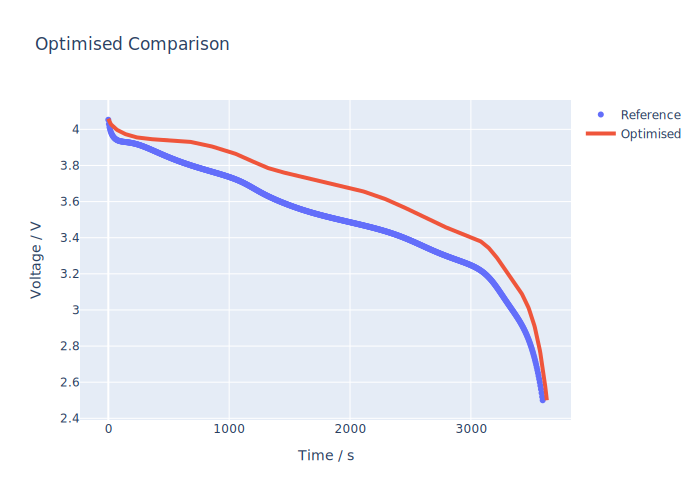

In [ ]:
if cost.update_capacity:
    problem._model.approximate_capacity(x)
pybop.quick_plot(problem, problem_inputs=x, title="Optimised Comparison");

### Cost Landscape

Finally, we can visualise the cost landscape and the path taken by the optimiser:


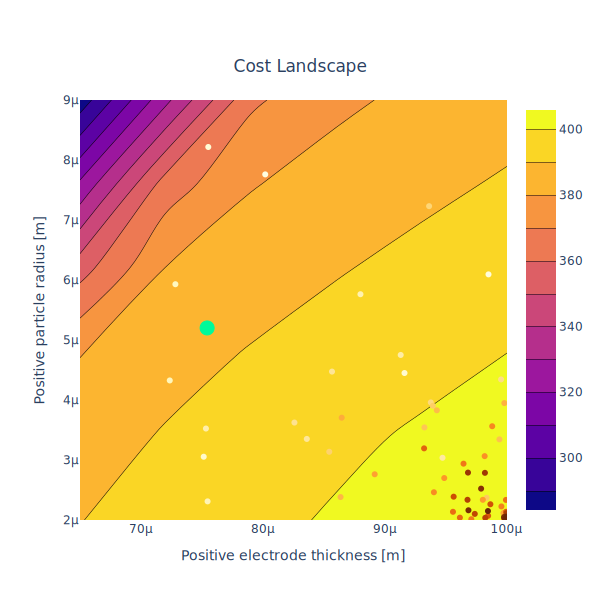

In [ ]:
if len(x) == 2:
    pybop.plot2d(optim, steps=6)